# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Wed Jun  4 10:25:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P0             31W /   80W |    1402MiB /   6144MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import VGG19Generator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/vgg19_model_mse",
    checkpoints_dir="../checkpoints/vgg19_model_mse",
    batch_size=2,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="vgg19",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: vgg19
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 2
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
)

Epoha 1/150: 100%|██████████| 229/229 [01:36<00:00,  2.38it/s, D_A=0.4630, D_B=0.0176, G=11.2908]


Epoha 1/150 - Train gubici: G: 12.8340, D_A: 0.2306, D_B: 0.2433 | Val gubici: G: 10.0051, Cycle: 6.6836
Novi najbolji validacijski cycle gubitak: 6.6836, spremam modele...
Novi najbolji validacijski GAN gubitak: 10.0051, spremam modele...


Epoha 2/150: 100%|██████████| 229/229 [01:28<00:00,  2.59it/s, D_A=0.0769, D_B=0.1080, G=4.4801] 


Epoha 2/150 - Train gubici: G: 9.4012, D_A: 0.1367, D_B: 0.0536 | Val gubici: G: 3.6765, Cycle: 2.7307
Novi najbolji validacijski cycle gubitak: 2.7307, spremam modele...
Novi najbolji validacijski GAN gubitak: 3.6765, spremam modele...


Epoha 3/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1973, D_B=0.1119, G=3.4674]


Epoha 3/150 - Train gubici: G: 4.3176, D_A: 0.1365, D_B: 0.0957 | Val gubici: G: 2.8302, Cycle: 1.8400
Novi najbolji validacijski cycle gubitak: 1.8400, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.8302, spremam modele...


Epoha 4/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1508, D_B=0.1385, G=3.0095]


Epoha 4/150 - Train gubici: G: 3.8283, D_A: 0.1031, D_B: 0.0952 | Val gubici: G: 2.7432, Cycle: 1.3733
Novi najbolji validacijski cycle gubitak: 1.3733, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.7432, spremam modele...


Epoha 5/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.3433, D_B=0.0745, G=2.5850]


Epoha 5/150 - Train gubici: G: 3.5555, D_A: 0.1264, D_B: 0.0841 | Val gubici: G: 2.7153, Cycle: 1.3949
Novi najbolji validacijski GAN gubitak: 2.7153, spremam modele...


Epoha 6/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1447, D_B=0.0613, G=3.3834]


Epoha 6/150 - Train gubici: G: 3.5602, D_A: 0.1148, D_B: 0.0839 | Val gubici: G: 3.5467, Cycle: 1.5286


Epoha 7/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0828, D_B=0.0751, G=4.0208]


Epoha 7/150 - Train gubici: G: 3.5078, D_A: 0.1174, D_B: 0.0853 | Val gubici: G: 3.2569, Cycle: 1.4798


Epoha 8/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1907, D_B=0.0875, G=3.3835]


Epoha 8/150 - Train gubici: G: 3.3077, D_A: 0.1291, D_B: 0.1066 | Val gubici: G: 2.6354, Cycle: 1.4552
Novi najbolji validacijski GAN gubitak: 2.6354, spremam modele...


Epoha 9/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0287, D_B=0.2128, G=2.2391]


Epoha 9/150 - Train gubici: G: 3.1126, D_A: 0.1276, D_B: 0.1281 | Val gubici: G: 1.8414, Cycle: 1.2251
Novi najbolji validacijski cycle gubitak: 1.2251, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.8414, spremam modele...


Epoha 10/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1129, D_B=0.0744, G=3.4087]


Epoha 10/150 - Train gubici: G: 2.9038, D_A: 0.2163, D_B: 0.1183 | Val gubici: G: 2.6565, Cycle: 1.3234


Epoha 11/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1000, D_B=0.0640, G=2.8239]


Epoha 11/150 - Train gubici: G: 2.9693, D_A: 0.1518, D_B: 0.1234 | Val gubici: G: 1.7635, Cycle: 1.2088
Novi najbolji validacijski cycle gubitak: 1.2088, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.7635, spremam modele...


Epoha 12/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0861, D_B=0.0913, G=3.3173]


Epoha 12/150 - Train gubici: G: 3.0688, D_A: 0.1064, D_B: 0.1086 | Val gubici: G: 2.4136, Cycle: 1.2989


Epoha 13/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0480, D_B=0.2529, G=3.3203]


Epoha 13/150 - Train gubici: G: 2.9893, D_A: 0.1037, D_B: 0.1086 | Val gubici: G: 2.8537, Cycle: 1.2700


Epoha 14/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0838, D_B=0.1005, G=2.8770]


Epoha 14/150 - Train gubici: G: 3.0061, D_A: 0.1012, D_B: 0.1135 | Val gubici: G: 2.2598, Cycle: 1.3201


Epoha 15/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1883, D_B=0.0514, G=2.6824]


Epoha 15/150 - Train gubici: G: 2.9453, D_A: 0.1049, D_B: 0.1173 | Val gubici: G: 2.4357, Cycle: 1.2437


Epoha 16/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0998, D_B=0.0830, G=3.1305]


Epoha 16/150 - Train gubici: G: 2.9115, D_A: 0.0941, D_B: 0.1571 | Val gubici: G: 3.0140, Cycle: 1.4685


Epoha 17/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0635, D_B=0.1977, G=2.1026]


Epoha 17/150 - Train gubici: G: 2.7385, D_A: 0.1391, D_B: 0.1210 | Val gubici: G: 2.6981, Cycle: 1.3789


Epoha 18/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0673, D_B=0.1442, G=2.3176]


Epoha 18/150 - Train gubici: G: 2.8146, D_A: 0.1020, D_B: 0.1108 | Val gubici: G: 2.6791, Cycle: 1.4958


Epoha 19/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0589, D_B=0.2239, G=2.9287]


Epoha 19/150 - Train gubici: G: 2.7843, D_A: 0.0950, D_B: 0.1247 | Val gubici: G: 2.2442, Cycle: 1.3320


Epoha 20/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1024, D_B=0.3667, G=2.8163]


Epoha 20/150 - Train gubici: G: 2.6103, D_A: 0.1097, D_B: 0.1805 | Val gubici: G: 2.6824, Cycle: 1.1547
Novi najbolji validacijski cycle gubitak: 1.1547, spremam modele...


Epoha 21/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0319, D_B=0.1578, G=3.2354]


Epoha 21/150 - Train gubici: G: 2.5859, D_A: 0.0872, D_B: 0.1393 | Val gubici: G: 2.5890, Cycle: 1.1748


Epoha 22/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0343, D_B=0.0911, G=2.6467]


Epoha 22/150 - Train gubici: G: 2.6258, D_A: 0.1019, D_B: 0.1186 | Val gubici: G: 1.9838, Cycle: 1.0937
Novi najbolji validacijski cycle gubitak: 1.0937, spremam modele...


Epoha 23/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0676, D_B=0.0339, G=3.2553]


Epoha 23/150 - Train gubici: G: 2.6187, D_A: 0.1029, D_B: 0.1185 | Val gubici: G: 2.9546, Cycle: 1.1481


Epoha 24/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0509, D_B=0.2182, G=2.3856]


Epoha 24/150 - Train gubici: G: 2.6809, D_A: 0.0918, D_B: 0.1141 | Val gubici: G: 2.5905, Cycle: 1.0927
Novi najbolji validacijski cycle gubitak: 1.0927, spremam modele...


Epoha 25/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1168, D_B=0.1095, G=3.4906]


Epoha 25/150 - Train gubici: G: 2.6682, D_A: 0.0942, D_B: 0.1137 | Val gubici: G: 2.2517, Cycle: 1.1566


Epoha 26/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1465, D_B=0.1618, G=3.3914]


Epoha 26/150 - Train gubici: G: 2.5873, D_A: 0.0958, D_B: 0.1380 | Val gubici: G: 2.3061, Cycle: 1.1926


Epoha 27/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1274, D_B=0.2081, G=2.2144]


Epoha 27/150 - Train gubici: G: 2.5225, D_A: 0.0897, D_B: 0.1397 | Val gubici: G: 3.1912, Cycle: 1.1335


Epoha 28/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1515, D_B=0.1674, G=1.8958]


Epoha 28/150 - Train gubici: G: 2.3389, D_A: 0.1116, D_B: 0.1453 | Val gubici: G: 2.2548, Cycle: 1.0086
Novi najbolji validacijski cycle gubitak: 1.0086, spremam modele...


Epoha 29/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1358, D_B=0.1528, G=2.8853]


Epoha 29/150 - Train gubici: G: 2.3074, D_A: 0.1163, D_B: 0.1560 | Val gubici: G: 1.6900, Cycle: 1.0253
Novi najbolji validacijski GAN gubitak: 1.6900, spremam modele...


Epoha 30/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0431, D_B=0.1599, G=1.7983]


Epoha 30/150 - Train gubici: G: 2.1902, D_A: 0.1294, D_B: 0.1602 | Val gubici: G: 1.9321, Cycle: 0.9356
Novi najbolji validacijski cycle gubitak: 0.9356, spremam modele...


Epoha 31/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1054, D_B=0.1990, G=2.2311]


Epoha 31/150 - Train gubici: G: 2.2113, D_A: 0.1284, D_B: 0.1621 | Val gubici: G: 2.3746, Cycle: 1.1331


Epoha 32/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0734, D_B=0.0787, G=1.9216]


Epoha 32/150 - Train gubici: G: 2.2164, D_A: 0.1376, D_B: 0.1654 | Val gubici: G: 1.5206, Cycle: 0.9434
Novi najbolji validacijski GAN gubitak: 1.5206, spremam modele...


Epoha 33/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0843, D_B=0.1954, G=2.0278]


Epoha 33/150 - Train gubici: G: 2.1557, D_A: 0.1331, D_B: 0.1645 | Val gubici: G: 2.6416, Cycle: 0.9916


Epoha 34/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2038, D_B=0.2753, G=1.9034]


Epoha 34/150 - Train gubici: G: 2.1584, D_A: 0.1374, D_B: 0.1648 | Val gubici: G: 2.0242, Cycle: 0.8814
Novi najbolji validacijski cycle gubitak: 0.8814, spremam modele...


Epoha 35/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1035, D_B=0.2486, G=1.9668]


Epoha 35/150 - Train gubici: G: 2.0861, D_A: 0.1280, D_B: 0.1660 | Val gubici: G: 2.1115, Cycle: 0.9342


Epoha 36/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1603, D_B=0.1330, G=3.7403]


Epoha 36/150 - Train gubici: G: 2.0765, D_A: 0.1335, D_B: 0.1779 | Val gubici: G: 1.5874, Cycle: 0.9524


Epoha 37/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0777, D_B=0.0635, G=1.6448]


Epoha 37/150 - Train gubici: G: 2.0153, D_A: 0.1503, D_B: 0.1732 | Val gubici: G: 1.6694, Cycle: 0.9256


Epoha 38/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1378, D_B=0.1619, G=1.8595]


Epoha 38/150 - Train gubici: G: 2.0064, D_A: 0.1363, D_B: 0.1605 | Val gubici: G: 1.8833, Cycle: 0.9221


Epoha 39/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1136, D_B=0.2573, G=1.5636]


Epoha 39/150 - Train gubici: G: 1.9812, D_A: 0.1433, D_B: 0.1660 | Val gubici: G: 1.9930, Cycle: 0.8309
Novi najbolji validacijski cycle gubitak: 0.8309, spremam modele...


Epoha 40/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0760, D_B=0.1966, G=1.7877]


Epoha 40/150 - Train gubici: G: 1.9792, D_A: 0.1331, D_B: 0.1594 | Val gubici: G: 2.2827, Cycle: 0.8474


Epoha 41/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1270, D_B=0.1704, G=1.5215]


Epoha 41/150 - Train gubici: G: 1.9846, D_A: 0.1464, D_B: 0.1576 | Val gubici: G: 2.7028, Cycle: 0.8014
Novi najbolji validacijski cycle gubitak: 0.8014, spremam modele...


Epoha 42/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.1934, D_B=0.1824, G=2.0365]


Epoha 42/150 - Train gubici: G: 1.9510, D_A: 0.1387, D_B: 0.1547 | Val gubici: G: 1.9935, Cycle: 0.7848
Novi najbolji validacijski cycle gubitak: 0.7848, spremam modele...


Epoha 43/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0760, D_B=0.1053, G=1.7353]


Epoha 43/150 - Train gubici: G: 1.9910, D_A: 0.1276, D_B: 0.1598 | Val gubici: G: 1.7542, Cycle: 0.8649


Epoha 44/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.0441, D_B=0.1559, G=1.9183]


Epoha 44/150 - Train gubici: G: 1.9224, D_A: 0.1380, D_B: 0.1563 | Val gubici: G: 1.3968, Cycle: 0.8119
Novi najbolji validacijski GAN gubitak: 1.3968, spremam modele...


Epoha 45/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1576, D_B=0.1302, G=2.5272]


Epoha 45/150 - Train gubici: G: 1.9760, D_A: 0.1285, D_B: 0.1531 | Val gubici: G: 1.2405, Cycle: 0.7514
Novi najbolji validacijski cycle gubitak: 0.7514, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.2405, spremam modele...


Epoha 46/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2465, D_B=0.0476, G=1.5794]   


Epoha 46/150 - Train gubici: G: 3.7772, D_A: 1.3672, D_B: 0.4213 | Val gubici: G: 1.4696, Cycle: 0.9176


Epoha 47/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2400, D_B=0.1974, G=1.8081]


Epoha 47/150 - Train gubici: G: 1.8134, D_A: 0.2419, D_B: 0.2136 | Val gubici: G: 1.3978, Cycle: 0.8055


Epoha 48/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2413, D_B=0.1806, G=2.0293]


Epoha 48/150 - Train gubici: G: 1.7695, D_A: 0.2423, D_B: 0.2028 | Val gubici: G: 1.7376, Cycle: 1.0571


Epoha 49/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2689, D_B=0.2056, G=1.6713]


Epoha 49/150 - Train gubici: G: 1.7813, D_A: 0.2410, D_B: 0.1881 | Val gubici: G: 1.2349, Cycle: 0.8724
Novi najbolji validacijski GAN gubitak: 1.2349, spremam modele...


Epoha 50/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2467, D_B=0.2029, G=1.7328]


Epoha 50/150 - Train gubici: G: 1.7949, D_A: 0.2432, D_B: 0.1781 | Val gubici: G: 1.9672, Cycle: 1.0172


Epoha 51/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2453, D_B=0.0798, G=2.3279]


Epoha 51/150 - Train gubici: G: 1.8758, D_A: 0.2457, D_B: 0.1594 | Val gubici: G: 1.9940, Cycle: 0.9081


Epoha 52/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2734, D_B=0.2505, G=1.9079]


Epoha 52/150 - Train gubici: G: 1.8829, D_A: 0.2485, D_B: 0.1392 | Val gubici: G: 1.6398, Cycle: 0.9233


Epoha 53/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2696, D_B=0.1848, G=1.8574]


Epoha 53/150 - Train gubici: G: 1.9572, D_A: 0.2501, D_B: 0.1308 | Val gubici: G: 2.1703, Cycle: 1.0448


Epoha 54/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.3352, D_B=0.0715, G=2.3611]


Epoha 54/150 - Train gubici: G: 1.9619, D_A: 0.2526, D_B: 0.1456 | Val gubici: G: 1.5834, Cycle: 1.0924


Epoha 55/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2654, D_B=0.0420, G=1.9143]


Epoha 55/150 - Train gubici: G: 1.9703, D_A: 0.2493, D_B: 0.1478 | Val gubici: G: 1.5974, Cycle: 1.0424


Epoha 56/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2591, D_B=0.1200, G=1.9891]


Epoha 56/150 - Train gubici: G: 1.9709, D_A: 0.2483, D_B: 0.1427 | Val gubici: G: 1.6004, Cycle: 1.0165


Epoha 57/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2919, D_B=0.0974, G=1.8966]


Epoha 57/150 - Train gubici: G: 1.9025, D_A: 0.2553, D_B: 0.1444 | Val gubici: G: 1.8302, Cycle: 1.0015


Epoha 58/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2504, D_B=0.1116, G=1.2364]


Epoha 58/150 - Train gubici: G: 1.7480, D_A: 0.2588, D_B: 0.1487 | Val gubici: G: 1.2543, Cycle: 0.8815


Epoha 59/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2884, D_B=0.1449, G=1.3247]


Epoha 59/150 - Train gubici: G: 1.7040, D_A: 0.2628, D_B: 0.1446 | Val gubici: G: 1.6717, Cycle: 0.8575


Epoha 60/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2655, D_B=0.1179, G=1.7480]


Epoha 60/150 - Train gubici: G: 1.6742, D_A: 0.2605, D_B: 0.1406 | Val gubici: G: 1.4981, Cycle: 0.8013


Epoha 61/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2560, D_B=0.0610, G=1.5205]


Epoha 61/150 - Train gubici: G: 1.6445, D_A: 0.2662, D_B: 0.1441 | Val gubici: G: 1.3943, Cycle: 0.7664


Epoha 62/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2668, D_B=0.1384, G=1.5768]


Epoha 62/150 - Train gubici: G: 1.6316, D_A: 0.2626, D_B: 0.1327 | Val gubici: G: 1.2273, Cycle: 0.7325
Novi najbolji validacijski cycle gubitak: 0.7325, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.2273, spremam modele...


Epoha 63/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2642, D_B=0.1402, G=2.0518]


Epoha 63/150 - Train gubici: G: 1.6168, D_A: 0.2586, D_B: 0.1381 | Val gubici: G: 1.2507, Cycle: 0.6960
Novi najbolji validacijski cycle gubitak: 0.6960, spremam modele...


Epoha 64/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2567, D_B=0.3080, G=1.2750]


Epoha 64/150 - Train gubici: G: 1.5935, D_A: 0.2665, D_B: 0.1375 | Val gubici: G: 2.2963, Cycle: 0.7306


Epoha 65/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3040, D_B=0.2055, G=1.7336]


Epoha 65/150 - Train gubici: G: 1.5932, D_A: 0.2609, D_B: 0.1341 | Val gubici: G: 1.4556, Cycle: 0.6821
Novi najbolji validacijski cycle gubitak: 0.6821, spremam modele...


Epoha 66/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2680, D_B=0.1032, G=1.1740]


Epoha 66/150 - Train gubici: G: 1.5928, D_A: 0.2581, D_B: 0.1243 | Val gubici: G: 1.3119, Cycle: 0.7147


Epoha 67/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3030, D_B=0.1319, G=1.6367]


Epoha 67/150 - Train gubici: G: 1.5824, D_A: 0.2608, D_B: 0.1261 | Val gubici: G: 1.7728, Cycle: 0.7972


Epoha 68/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2436, D_B=0.0743, G=1.3950]


Epoha 68/150 - Train gubici: G: 1.5585, D_A: 0.2610, D_B: 0.1236 | Val gubici: G: 1.4152, Cycle: 0.6641
Novi najbolji validacijski cycle gubitak: 0.6641, spremam modele...


Epoha 69/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3126, D_B=0.1544, G=1.9461]  


Epoha 69/150 - Train gubici: G: 2.8077, D_A: 0.2593, D_B: 0.7500 | Val gubici: G: 1.7476, Cycle: 1.1530


Epoha 70/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2488, D_B=0.2634, G=1.7499]


Epoha 70/150 - Train gubici: G: 1.7735, D_A: 0.2526, D_B: 0.2288 | Val gubici: G: 1.5743, Cycle: 0.9731


Epoha 71/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2467, D_B=0.2222, G=1.4698]


Epoha 71/150 - Train gubici: G: 1.6851, D_A: 0.2571, D_B: 0.2032 | Val gubici: G: 1.2778, Cycle: 0.7332


Epoha 72/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2298, D_B=0.2153, G=1.4720]


Epoha 72/150 - Train gubici: G: 1.6493, D_A: 0.2545, D_B: 0.1872 | Val gubici: G: 1.2440, Cycle: 0.7079


Epoha 73/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2476, D_B=0.1394, G=1.6085]


Epoha 73/150 - Train gubici: G: 1.6572, D_A: 0.2520, D_B: 0.1699 | Val gubici: G: 1.2376, Cycle: 0.6905


Epoha 74/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3000, D_B=0.2165, G=2.0041]


Epoha 74/150 - Train gubici: G: 1.6291, D_A: 0.2580, D_B: 0.1500 | Val gubici: G: 1.4075, Cycle: 0.7791


Epoha 75/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2325, D_B=0.0781, G=1.2069]


Epoha 75/150 - Train gubici: G: 1.6179, D_A: 0.2451, D_B: 0.1377 | Val gubici: G: 1.5918, Cycle: 0.7094


Epoha 76/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2475, D_B=0.1206, G=1.5070]


Epoha 76/150 - Train gubici: G: 1.6323, D_A: 0.2467, D_B: 0.1250 | Val gubici: G: 1.5346, Cycle: 0.7139


Epoha 77/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2379, D_B=0.1100, G=1.7658]


Epoha 77/150 - Train gubici: G: 1.6389, D_A: 0.2478, D_B: 0.1143 | Val gubici: G: 1.5887, Cycle: 0.6138
Novi najbolji validacijski cycle gubitak: 0.6138, spremam modele...


Epoha 78/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2060, D_B=0.1283, G=1.4881]


Epoha 78/150 - Train gubici: G: 1.6209, D_A: 0.2466, D_B: 0.1073 | Val gubici: G: 2.1415, Cycle: 0.7979


Epoha 79/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3309, D_B=0.0878, G=1.4654]


Epoha 79/150 - Train gubici: G: 1.5804, D_A: 0.2444, D_B: 0.1080 | Val gubici: G: 1.5932, Cycle: 0.7005


Epoha 80/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2189, D_B=0.1253, G=1.3951]


Epoha 80/150 - Train gubici: G: 1.5799, D_A: 0.2451, D_B: 0.1130 | Val gubici: G: 1.4013, Cycle: 0.7902


Epoha 81/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2875, D_B=0.2189, G=1.8486]


Epoha 81/150 - Train gubici: G: 1.5733, D_A: 0.2469, D_B: 0.1115 | Val gubici: G: 1.3593, Cycle: 0.6478


Epoha 82/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2244, D_B=0.1122, G=1.8711]


Epoha 82/150 - Train gubici: G: 1.5523, D_A: 0.2432, D_B: 0.1148 | Val gubici: G: 1.6576, Cycle: 0.7292


Epoha 83/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2241, D_B=0.0520, G=1.4559]


Epoha 83/150 - Train gubici: G: 1.5476, D_A: 0.2443, D_B: 0.1101 | Val gubici: G: 1.4768, Cycle: 0.6931


Epoha 84/150: 100%|██████████| 229/229 [01:28<00:00,  2.59it/s, D_A=0.2197, D_B=0.1503, G=1.3432]


Epoha 84/150 - Train gubici: G: 1.5455, D_A: 0.2440, D_B: 0.1123 | Val gubici: G: 1.4983, Cycle: 0.6184


Epoha 85/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2669, D_B=0.0379, G=1.1085]


Epoha 85/150 - Train gubici: G: 1.5580, D_A: 0.2429, D_B: 0.1081 | Val gubici: G: 1.3155, Cycle: 0.6801


Epoha 86/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2768, D_B=0.0905, G=1.5043]


Epoha 86/150 - Train gubici: G: 1.5474, D_A: 0.2417, D_B: 0.1088 | Val gubici: G: 1.7265, Cycle: 0.6363


Epoha 87/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2716, D_B=0.0892, G=1.4298]


Epoha 87/150 - Train gubici: G: 1.5498, D_A: 0.2407, D_B: 0.1093 | Val gubici: G: 1.5531, Cycle: 0.6115
Novi najbolji validacijski cycle gubitak: 0.6115, spremam modele...


Epoha 88/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2578, D_B=0.0897, G=1.2798]


Epoha 88/150 - Train gubici: G: 1.5536, D_A: 0.2433, D_B: 0.1066 | Val gubici: G: 1.1869, Cycle: 0.6290
Novi najbolji validacijski GAN gubitak: 1.1869, spremam modele...


Epoha 89/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2208, D_B=0.0672, G=1.3777]


Epoha 89/150 - Train gubici: G: 1.5475, D_A: 0.2368, D_B: 0.1075 | Val gubici: G: 1.8861, Cycle: 0.6173


Epoha 90/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2662, D_B=0.1481, G=1.8662]


Epoha 90/150 - Train gubici: G: 1.5576, D_A: 0.2391, D_B: 0.1044 | Val gubici: G: 1.1299, Cycle: 0.6688
Novi najbolji validacijski GAN gubitak: 1.1299, spremam modele...


Epoha 91/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2397, D_B=0.0768, G=1.8343]


Epoha 91/150 - Train gubici: G: 1.5706, D_A: 0.2379, D_B: 0.1037 | Val gubici: G: 1.1108, Cycle: 0.6350
Novi najbolji validacijski GAN gubitak: 1.1108, spremam modele...


Epoha 92/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2052, D_B=0.0451, G=1.5798]


Epoha 92/150 - Train gubici: G: 1.5614, D_A: 0.2379, D_B: 0.0984 | Val gubici: G: 1.4721, Cycle: 0.6694


Epoha 93/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2256, D_B=0.0397, G=1.7886]


Epoha 93/150 - Train gubici: G: 1.5747, D_A: 0.2350, D_B: 0.1016 | Val gubici: G: 1.5876, Cycle: 0.5954
Novi najbolji validacijski cycle gubitak: 0.5954, spremam modele...


Epoha 94/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2121, D_B=0.0787, G=1.8263]


Epoha 94/150 - Train gubici: G: 1.5723, D_A: 0.2339, D_B: 0.0991 | Val gubici: G: 1.6395, Cycle: 0.5839
Novi najbolji validacijski cycle gubitak: 0.5839, spremam modele...


Epoha 95/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2033, D_B=0.1006, G=1.8553]


Epoha 95/150 - Train gubici: G: 1.5780, D_A: 0.2329, D_B: 0.0933 | Val gubici: G: 1.4061, Cycle: 0.6632


Epoha 96/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2298, D_B=0.0998, G=1.4322]


Epoha 96/150 - Train gubici: G: 1.5868, D_A: 0.2369, D_B: 0.0961 | Val gubici: G: 1.9222, Cycle: 0.5732
Novi najbolji validacijski cycle gubitak: 0.5732, spremam modele...


Epoha 97/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2113, D_B=0.0615, G=1.4869]


Epoha 97/150 - Train gubici: G: 1.5988, D_A: 0.2323, D_B: 0.0916 | Val gubici: G: 1.6048, Cycle: 0.7070


Epoha 98/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2798, D_B=0.2142, G=2.1736]


Epoha 98/150 - Train gubici: G: 1.5844, D_A: 0.2328, D_B: 0.0862 | Val gubici: G: 1.2045, Cycle: 0.6173


Epoha 99/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1985, D_B=0.0898, G=1.5609]


Epoha 99/150 - Train gubici: G: 1.5909, D_A: 0.2294, D_B: 0.0895 | Val gubici: G: 1.5397, Cycle: 0.6285


Epoha 100/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2069, D_B=0.1486, G=1.7116]


Epoha 100/150 - Train gubici: G: 1.5875, D_A: 0.2328, D_B: 0.0873 | Val gubici: G: 1.5852, Cycle: 0.6169


Epoha 101/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2726, D_B=0.0424, G=1.5012]


Epoha 101/150 - Train gubici: G: 1.5989, D_A: 0.2293, D_B: 0.0897 | Val gubici: G: 1.4089, Cycle: 0.6216


Epoha 102/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2550, D_B=0.0966, G=1.5169]


Epoha 102/150 - Train gubici: G: 1.6079, D_A: 0.2279, D_B: 0.0846 | Val gubici: G: 1.6092, Cycle: 0.6714


Epoha 103/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2363, D_B=0.0588, G=1.2408]


Epoha 103/150 - Train gubici: G: 1.6262, D_A: 0.2293, D_B: 0.0796 | Val gubici: G: 1.5541, Cycle: 0.5899


Epoha 104/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1022, D_B=0.0340, G=1.2452]


Epoha 104/150 - Train gubici: G: 1.6182, D_A: 0.2261, D_B: 0.0843 | Val gubici: G: 1.6381, Cycle: 0.5855


Epoha 105/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2078, D_B=0.0829, G=1.3109]


Epoha 105/150 - Train gubici: G: 1.6199, D_A: 0.2283, D_B: 0.0771 | Val gubici: G: 2.0471, Cycle: 0.6696


Epoha 106/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2520, D_B=0.0942, G=1.8643]


Epoha 106/150 - Train gubici: G: 1.6258, D_A: 0.2270, D_B: 0.0774 | Val gubici: G: 1.7511, Cycle: 0.5701
Novi najbolji validacijski cycle gubitak: 0.5701, spremam modele...


Epoha 107/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1863, D_B=0.0699, G=1.5886]


Epoha 107/150 - Train gubici: G: 1.6400, D_A: 0.2260, D_B: 0.0785 | Val gubici: G: 1.8457, Cycle: 0.5780


Epoha 108/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1240, D_B=0.0652, G=1.7712]


Epoha 108/150 - Train gubici: G: 1.6358, D_A: 0.2250, D_B: 0.0724 | Val gubici: G: 1.8739, Cycle: 0.5933


Epoha 109/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0609, D_B=0.1461, G=1.8508]


Epoha 109/150 - Train gubici: G: 1.6547, D_A: 0.2255, D_B: 0.0746 | Val gubici: G: 1.9238, Cycle: 0.6643


Epoha 110/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2694, D_B=0.0424, G=1.3286]


Epoha 110/150 - Train gubici: G: 1.6778, D_A: 0.2252, D_B: 0.0699 | Val gubici: G: 1.5216, Cycle: 0.5904


Epoha 111/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0841, D_B=0.0463, G=2.3327]


Epoha 111/150 - Train gubici: G: 1.6635, D_A: 0.2219, D_B: 0.0722 | Val gubici: G: 2.0591, Cycle: 0.6841


Epoha 112/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2282, D_B=0.0343, G=1.3200]


Epoha 112/150 - Train gubici: G: 1.6637, D_A: 0.2240, D_B: 0.0705 | Val gubici: G: 1.9633, Cycle: 0.5752


Epoha 113/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1003, D_B=0.0664, G=2.3926]


Epoha 113/150 - Train gubici: G: 1.6687, D_A: 0.2199, D_B: 0.0663 | Val gubici: G: 1.7873, Cycle: 0.6528


Epoha 114/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2637, D_B=0.0268, G=1.7179]


Epoha 114/150 - Train gubici: G: 1.6556, D_A: 0.2187, D_B: 0.0659 | Val gubici: G: 1.6764, Cycle: 0.6263


Epoha 115/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2216, D_B=0.0540, G=1.6577]


Epoha 115/150 - Train gubici: G: 1.6761, D_A: 0.2183, D_B: 0.0681 | Val gubici: G: 1.8772, Cycle: 0.6190


Epoha 116/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1735, D_B=0.0310, G=1.8077]


Epoha 116/150 - Train gubici: G: 1.6910, D_A: 0.2143, D_B: 0.0618 | Val gubici: G: 1.8005, Cycle: 0.6174


Epoha 117/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2176, D_B=0.0579, G=1.6993]


Epoha 117/150 - Train gubici: G: 1.7064, D_A: 0.2162, D_B: 0.0631 | Val gubici: G: 2.0791, Cycle: 0.6400


Epoha 118/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2042, D_B=0.0407, G=1.6022]


Epoha 118/150 - Train gubici: G: 1.6934, D_A: 0.2138, D_B: 0.0637 | Val gubici: G: 1.5487, Cycle: 0.5891


Epoha 119/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2260, D_B=0.0551, G=1.6439]


Epoha 119/150 - Train gubici: G: 1.7035, D_A: 0.2134, D_B: 0.0647 | Val gubici: G: 1.9339, Cycle: 0.5851


Epoha 120/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2377, D_B=0.0633, G=1.7189]


Epoha 120/150 - Train gubici: G: 1.7134, D_A: 0.2132, D_B: 0.0566 | Val gubici: G: 2.0256, Cycle: 0.5994


Epoha 121/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2129, D_B=0.0475, G=1.4796]


Epoha 121/150 - Train gubici: G: 1.7311, D_A: 0.2126, D_B: 0.0531 | Val gubici: G: 1.6834, Cycle: 0.6125


Epoha 122/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1803, D_B=0.0453, G=1.6549]


Epoha 122/150 - Train gubici: G: 1.7406, D_A: 0.2102, D_B: 0.0575 | Val gubici: G: 2.0756, Cycle: 0.6049


Epoha 123/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1988, D_B=0.0667, G=1.2595]


Epoha 123/150 - Train gubici: G: 1.7347, D_A: 0.2084, D_B: 0.0553 | Val gubici: G: 1.9558, Cycle: 0.6181


Epoha 124/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2395, D_B=0.0666, G=1.9724]


Epoha 124/150 - Train gubici: G: 1.7537, D_A: 0.2065, D_B: 0.0555 | Val gubici: G: 1.7682, Cycle: 0.5941


Epoha 125/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2870, D_B=0.0353, G=1.8358]


Epoha 125/150 - Train gubici: G: 1.7523, D_A: 0.2059, D_B: 0.0537 | Val gubici: G: 1.9083, Cycle: 0.6457


Epoha 126/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1913, D_B=0.0448, G=1.7180]


Epoha 126/150 - Train gubici: G: 1.7587, D_A: 0.2052, D_B: 0.0512 | Val gubici: G: 2.0280, Cycle: 0.6237


Epoha 127/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2354, D_B=0.0578, G=1.8597]


Epoha 127/150 - Train gubici: G: 1.7731, D_A: 0.2044, D_B: 0.0482 | Val gubici: G: 2.0595, Cycle: 0.6044


Epoha 128/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2291, D_B=0.0569, G=1.9687]


Epoha 128/150 - Train gubici: G: 1.7882, D_A: 0.2018, D_B: 0.0466 | Val gubici: G: 1.9694, Cycle: 0.5972


Epoha 129/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1597, D_B=0.0502, G=1.6829]


Epoha 129/150 - Train gubici: G: 1.7745, D_A: 0.2011, D_B: 0.0486 | Val gubici: G: 1.9505, Cycle: 0.6126


Epoha 130/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2249, D_B=0.0551, G=1.6729]


Epoha 130/150 - Train gubici: G: 1.7919, D_A: 0.2006, D_B: 0.0475 | Val gubici: G: 2.0800, Cycle: 0.6114


Epoha 131/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1877, D_B=0.0287, G=1.5429]


Epoha 131/150 - Train gubici: G: 1.7966, D_A: 0.1985, D_B: 0.0442 | Val gubici: G: 1.9665, Cycle: 0.6039


Epoha 132/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2336, D_B=0.0473, G=1.5455]


Epoha 132/150 - Train gubici: G: 1.8103, D_A: 0.1979, D_B: 0.0426 | Val gubici: G: 2.2422, Cycle: 0.6250


Epoha 133/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2194, D_B=0.0628, G=1.4246]


Epoha 133/150 - Train gubici: G: 1.8161, D_A: 0.1971, D_B: 0.0432 | Val gubici: G: 2.4790, Cycle: 0.5896


Epoha 134/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2288, D_B=0.0307, G=2.0153]


Epoha 134/150 - Train gubici: G: 1.8273, D_A: 0.1949, D_B: 0.0410 | Val gubici: G: 2.1067, Cycle: 0.5994


Epoha 135/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2161, D_B=0.0346, G=1.7447]


Epoha 135/150 - Train gubici: G: 1.8310, D_A: 0.1945, D_B: 0.0398 | Val gubici: G: 2.4274, Cycle: 0.6038


Epoha 136/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2101, D_B=0.0296, G=2.0191]


Epoha 136/150 - Train gubici: G: 1.8377, D_A: 0.1931, D_B: 0.0374 | Val gubici: G: 2.4292, Cycle: 0.6094


Epoha 137/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1732, D_B=0.0333, G=2.0783]


Epoha 137/150 - Train gubici: G: 1.8482, D_A: 0.1903, D_B: 0.0370 | Val gubici: G: 2.4422, Cycle: 0.6289


Epoha 138/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.0675, D_B=0.0404, G=1.9245]


Epoha 138/150 - Train gubici: G: 1.8456, D_A: 0.1906, D_B: 0.0366 | Val gubici: G: 2.4685, Cycle: 0.5977


Epoha 139/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1823, D_B=0.0316, G=2.0109]


Epoha 139/150 - Train gubici: G: 1.8502, D_A: 0.1880, D_B: 0.0347 | Val gubici: G: 2.2655, Cycle: 0.6042


Epoha 140/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1840, D_B=0.0364, G=1.8240]


Epoha 140/150 - Train gubici: G: 1.8596, D_A: 0.1875, D_B: 0.0326 | Val gubici: G: 2.4154, Cycle: 0.6324


Epoha 141/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1760, D_B=0.0305, G=1.5716]


Epoha 141/150 - Train gubici: G: 1.8650, D_A: 0.1850, D_B: 0.0316 | Val gubici: G: 2.3540, Cycle: 0.6030


Epoha 142/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1930, D_B=0.0379, G=1.5764]


Epoha 142/150 - Train gubici: G: 1.8681, D_A: 0.1849, D_B: 0.0309 | Val gubici: G: 2.5442, Cycle: 0.6080


Epoha 143/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1975, D_B=0.0353, G=1.8801]


Epoha 143/150 - Train gubici: G: 1.8752, D_A: 0.1836, D_B: 0.0296 | Val gubici: G: 2.7367, Cycle: 0.6035


Epoha 144/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2247, D_B=0.0213, G=1.9369]


Epoha 144/150 - Train gubici: G: 1.8712, D_A: 0.1828, D_B: 0.0292 | Val gubici: G: 2.6196, Cycle: 0.6017


Epoha 145/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2498, D_B=0.0199, G=1.8238]


Epoha 145/150 - Train gubici: G: 1.8763, D_A: 0.1817, D_B: 0.0287 | Val gubici: G: 2.7561, Cycle: 0.6121


Epoha 146/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1739, D_B=0.0279, G=1.7324]


Epoha 146/150 - Train gubici: G: 1.8801, D_A: 0.1808, D_B: 0.0273 | Val gubici: G: 2.8934, Cycle: 0.6127


Epoha 147/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.2036, D_B=0.0276, G=1.8175]


Epoha 147/150 - Train gubici: G: 1.8811, D_A: 0.1795, D_B: 0.0265 | Val gubici: G: 2.8110, Cycle: 0.6095


Epoha 148/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1642, D_B=0.0215, G=1.7271]


Epoha 148/150 - Train gubici: G: 1.8831, D_A: 0.1785, D_B: 0.0257 | Val gubici: G: 2.7329, Cycle: 0.6088


Epoha 149/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1675, D_B=0.0172, G=1.9880]


Epoha 149/150 - Train gubici: G: 1.8785, D_A: 0.1775, D_B: 0.0251 | Val gubici: G: 2.9133, Cycle: 0.6064


Epoha 150/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.1627, D_B=0.0192, G=1.9401]


Epoha 150/150 - Train gubici: G: 1.8792, D_A: 0.1774, D_B: 0.0248 | Val gubici: G: 2.9032, Cycle: 0.6074

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.28it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8312
  MSE: 0.003681
  PSNR: 24.67 dB

T2 -> T1 translacija:
  SSIM: 0.8697
  MSE: 0.003501
  PSNR: 25.01 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9180
  MSE: 0.001322
  PSNR: 28.86 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9130
  MSE: 0.001475
  PSNR: 28.42 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7339
  MSE: 0.006080
  PSNR: 22.49 dB

T2 -> T1 translacija:
  SSIM: 0.7894
  MSE: 0.005783
  PSNR: 22.84 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8628
  MSE: 0.002184
  PSNR: 26.68 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8545
  MSE: 0.002437
  PSNR: 26.24 dB


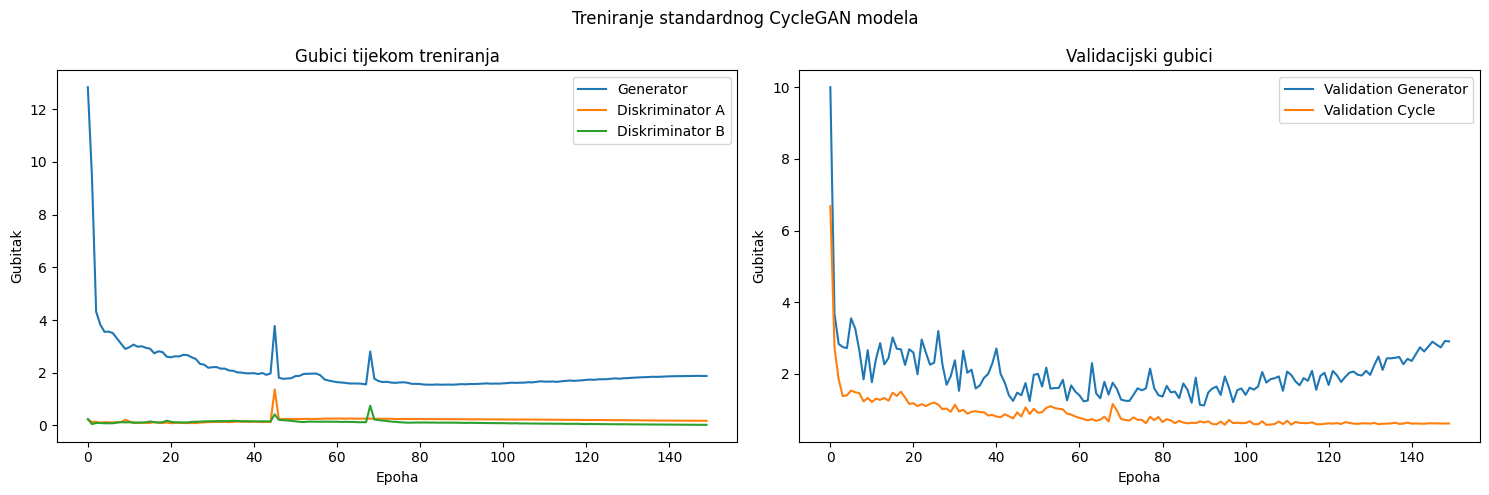

In [17]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.25it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8312
  MSE: 0.003681
  PSNR: 24.67 dB

T2 -> T1 translacija:
  SSIM: 0.8697
  MSE: 0.003501
  PSNR: 25.01 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9180
  MSE: 0.001322
  PSNR: 28.86 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9130
  MSE: 0.001475
  PSNR: 28.42 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7339
  MSE: 0.006080
  PSNR: 22.49 dB

T2 -> T1 translacija:
  SSIM: 0.7894
  MSE: 0.005783
  PSNR: 22.84 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8628
  MSE: 0.002184
  PSNR: 26.68 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8545
  MSE: 0.002437
  PSNR: 26.24 dB


Vizualizacija rezultata na test setu:


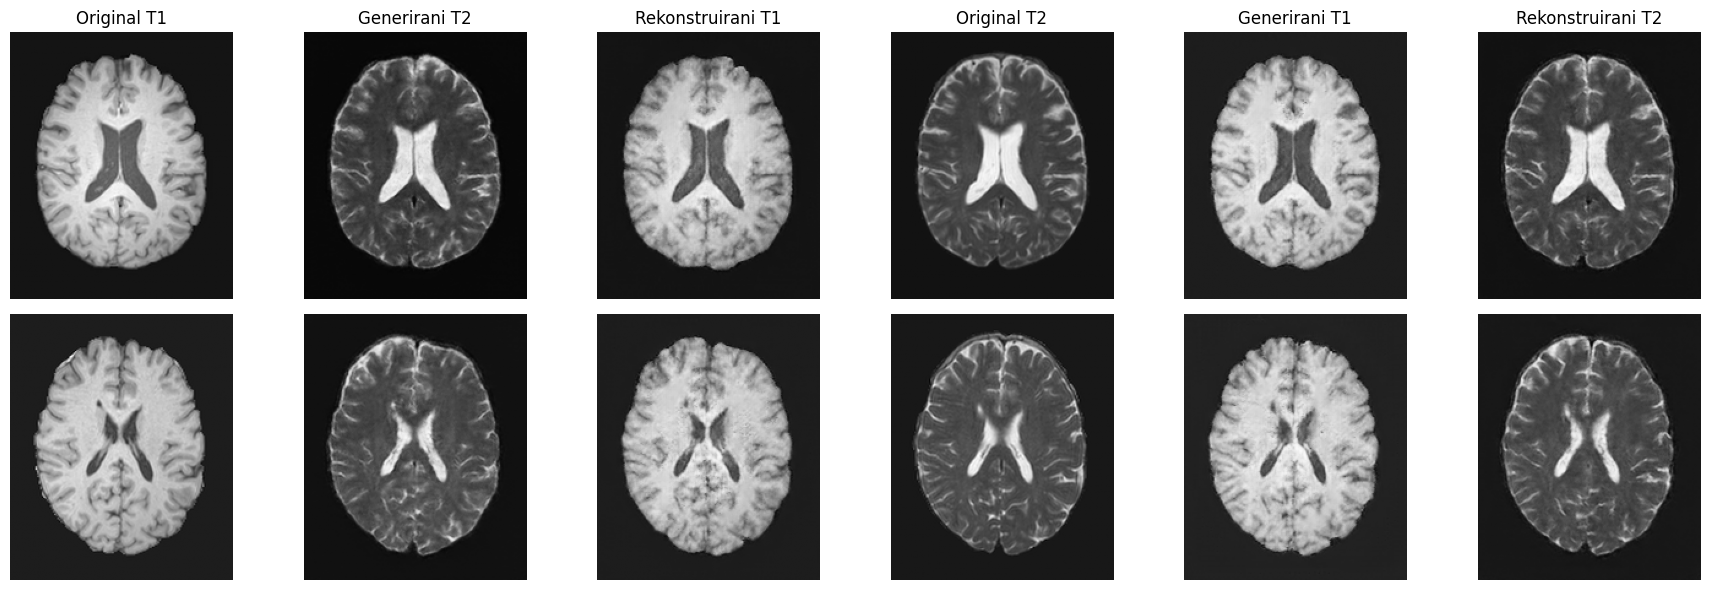

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=2, config=config)

In [11]:
best_G_AB_cycle = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [12]:
print("Testiranje najboljih modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.23it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8289
  MSE: 0.003798
  PSNR: 24.47 dB

T2 -> T1 translacija:
  SSIM: 0.8684
  MSE: 0.003624
  PSNR: 24.85 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9311
  MSE: 0.001100
  PSNR: 29.64 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9225
  MSE: 0.001338
  PSNR: 28.79 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7309
  MSE: 0.006273
  PSNR: 22.29 dB

T2 -> T1 translacija:
  SSIM: 0.7881
  MSE: 0.005986
  PSNR: 22.67 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8848
  MSE: 0.001816
  PSNR: 27.46 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8707
  MSE: 0.002210
  PSNR: 26.61 dB


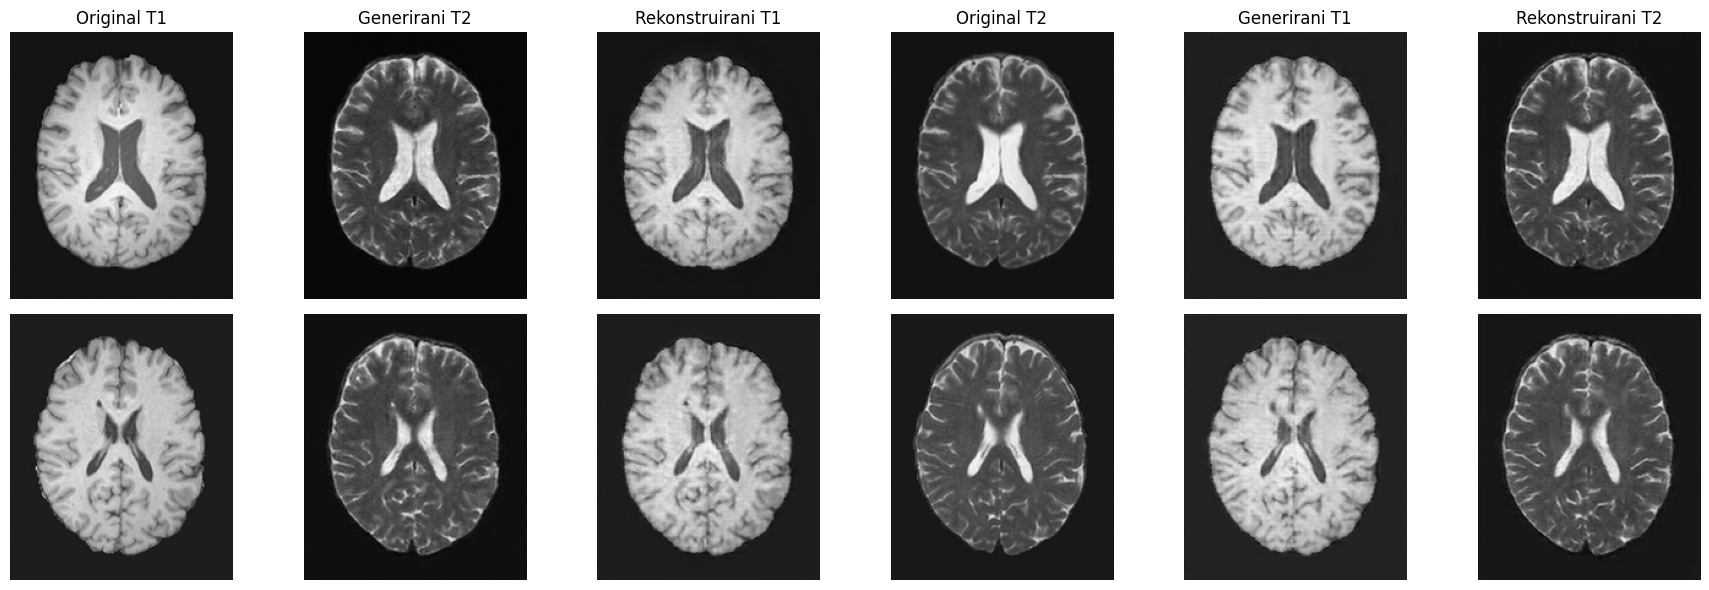

In [13]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=2, config=config
)

In [14]:
best_G_AB_gan = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [15]:
print("Testiranje najboljih modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.22it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8307
  MSE: 0.004483
  PSNR: 23.63 dB

T2 -> T1 translacija:
  SSIM: 0.8621
  MSE: 0.004835
  PSNR: 23.34 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9241
  MSE: 0.001301
  PSNR: 28.92 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9214
  MSE: 0.001544
  PSNR: 28.19 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7319
  MSE: 0.007404
  PSNR: 21.45 dB

T2 -> T1 translacija:
  SSIM: 0.7769
  MSE: 0.007986
  PSNR: 21.16 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8735
  MSE: 0.002149
  PSNR: 26.75 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8708
  MSE: 0.002550
  PSNR: 26.01 dB


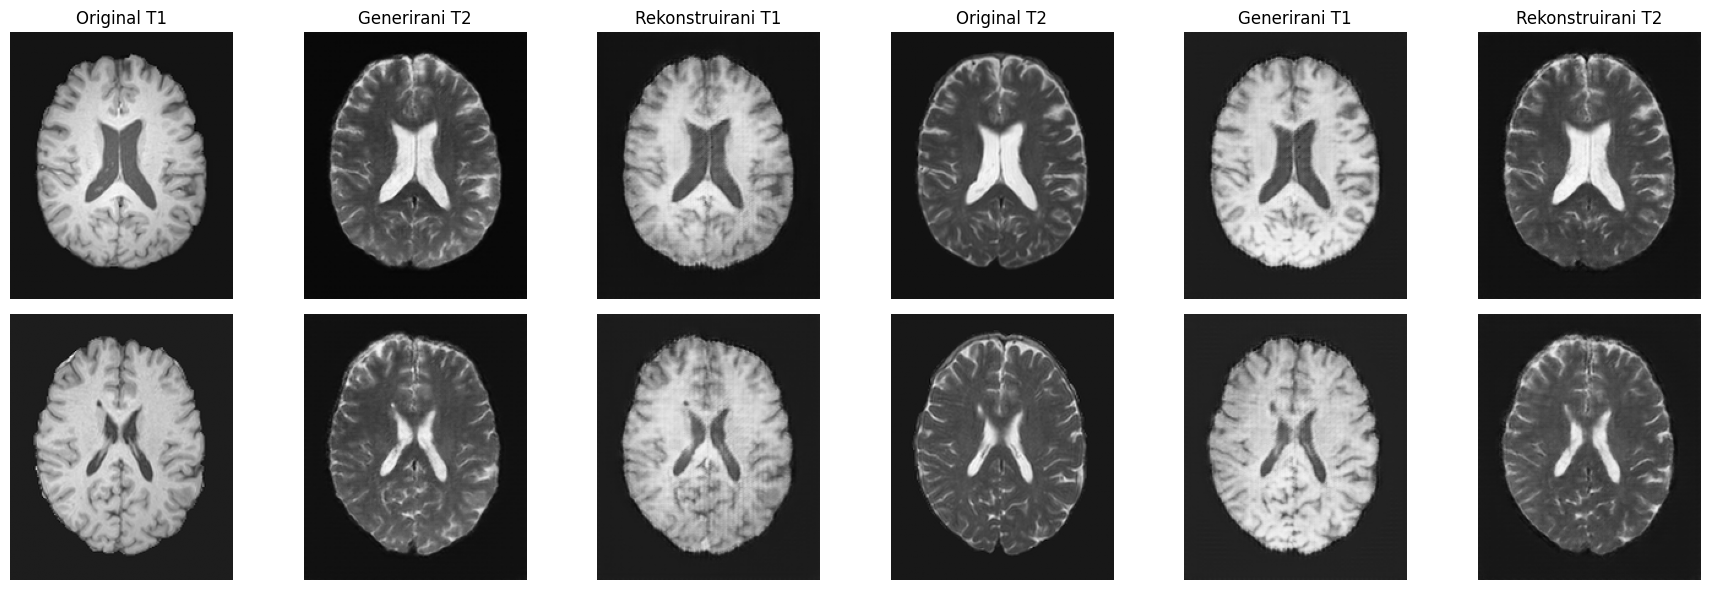

In [16]:
visualize_results(
    best_G_AB_gan, best_G_BA_gan, test_dataloader, num_samples=2, config=config
)